# Learning progress: Resultados de Evaluación del BERT a lo largo del finetuning
## Datos:
* Muestra fenotipos/etiquetas: [index-phenotypes.csv](../../../data/phenotypes/index-phenotypes.csv)
  * $M = 100$ tags o fenotipos de entrenamiento. 
  * Todos los pares de tags fueron usados para la evaluación de training.
* Abstracts de los que se tomó la muestra: [abstracts.csv](../../../data/abstracts/abstracts.csv)
  * $N = 11613$ abstracts.
  * Obtenidos de una búsqueda en [pubmed](https://pubmed.ncbi.nlm.nih.gov/)
* Fenotipos test: [leaf-phenotypes.csv](../../../data/phenotypes/leaf-phenotypes.csv) = nodos hoja HPO:PhenotypicAbnormality.
  * Muestra de 1000 pares de fenotipos para la evaluación de test [pairs-test.csv](../../../data/evaluation/pairs-test.csv).
## Resumen del modelo:
Modelo original: [pritamdeka](https://huggingface.co/pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb).  
Modelo obtenido: [README.md](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/README.md)  


Parámetros de entrenamiento:
* batch_size = 16, longitud del dataloader = 726 = nº batches / epoch.
* epochs = 8
* evaluation steps = 72 (10 pasos de evaluación / epoch)
* warmup steps = 145
* Loss Function: BatchAllTripletLoss con distancia de coseno y margin=0.3743.
* Evaluation Function: SequentialEvaluator compuesto por:
  1. EmbeddingSimilarityEvaluator(main_similarity=SimilarityFunction.COSINE): para cada par de muestra obtiene la similitud coseno y calcula los scores de correlación de pearson y spearman respecto de las similitudes gold pasadas por parámetro (lin entre fenotipos). Devuelve el score de spearman.
    * Train: resultados en [similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/similarity_evaluation_train_results.csv)
    * Test: [similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/similarity_evaluation_test_results.csv)
  2. MSESimilarityEvaluator(main_similarity=SimilarityFunction.COSINE), implementado por mí: funciona igual que el anterior pero el score devuelto es el MSE entre las similitudes coseno y las gold.
    * Train: [MSE_similarity_evaluation_train_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/MSE_similarity_evaluation_train_results.csv)
    * Test: [MSE_similarity_evaluation_test_results.csv](../../../output/fine-tuned-bio-bert-ev-mse-01-04-2024/eval/MSE_similarity_evaluation_test_results.csv)
* save_best_model = True : No debería haberlo hecho. El modelo final fue el que tuvo mayor correlación de Spearman de Test.
* Resto de hiperparámetros por defecto: lr = 2E-5, weight_decay = 0.01, max_grad_norm = 1.

## 1. Carga de datos

In [1]:
# Import global variables from project_config.py

import os
import sys
from IPython.core.getipython import get_ipython

# Absolute path of the current notebook
notebook_path = os.path.realpath(os.path.join(os.getcwd(), get_ipython().starting_dir))
# Add module to system path
config_path = os.path.join(os.path.dirname(os.path.dirname(notebook_path)), "project_config")
sys.path.append(config_path)

import project_config
from project_config import *

print(f"SEED={SEED}")

SEED=42


In [2]:
# IMPORTS
from cmath import nan
import sentence_transformers
import torch
from sentence_transformers import SentenceTransformer
import numpy as np
import pandas as pd

from pyhpo import Ontology

from sentence_transformers.evaluation import SimilarityFunction
import MSESimilarityEvaluator as MSESim
from MSESimilarityEvaluator import MSESimilarityEvaluator
import time

from matplotlib import pyplot as plt

torch.manual_seed(SEED)

In [3]:
# 1. Cargar todos los datos (crudos)

# 1.1 BERT de partida

bertmodel = SentenceTransformer(PRITAMDEKAMODEL) # Original
model = bertmodel # Para finetunear

# 1.2 Ontología

onto = Ontology(PATH_ONTO)

# 1.3 Datos de entrenamiento y evaluación (csv)

# abstracts (train)
path_abstracts_train = os.path.join(PATH_ABSTRACTS, 'abstracts-train.csv')
dTrain = pd.read_csv(path_abstracts_train, sep='\t', low_memory=False, na_values=['', nan])

# fenotipos hoja
path_phenotypes = os.path.join(PATH_PHENOTYPES, 'leaf-phenotypes.csv')
dfPhenotypes = pd.read_csv(path_phenotypes, sep=';', low_memory=False, na_values=['', nan])

# fenotipos tags
path_index = os.path.join(PATH_PHENOTYPES, 'index.csv')
dfIndex = pd.read_csv(path_index, sep='\t', low_memory=False, na_values=['', nan])

# pares fenotipos train
path_pairs_train = os.path.join(PATH_EVALUATION, 'pairs-val.csv')
dfVal = pd.read_csv(path_pairs_train, sep='\t', low_memory=False, na_values=['', nan])

# test
path_pairs_test = os.path.join(PATH_EVALUATION, 'pairs-test.csv')
dfTest = pd.read_csv(path_pairs_test, sep='\t', low_memory=False, na_values=['', nan])


## 2. Preparación del entrenamiento
Vamos a construir los dataloaders y las funciones de pérdida y evaluación.

### Dataloaders

In [4]:
from torch.utils.data import DataLoader, Dataset
from sentence_transformers import SentenceTransformer, SentencesDataset, losses, evaluation, InputExample

# 2.1. Ejemplos de entrenamiento
tags = dfIndex['phenotypeName']
numlabels = len(tags)
mapping = {tag: i for i, tag in enumerate(tags)}

def getLabelNumber(phenotypeName):
    return mapping[phenotypeName]

abstractsTrain = [InputExample(texts=[x], label=mapping[y]) for x, y in zip(dTrain['clean_abstract'], dTrain['phenotypeName'])]
train_dataloader = DataLoader(abstractsTrain, shuffle=True, batch_size=BATCH_SIZE)

# 2.2. Ejemplos de validación

ltrain1 = dfVal['phenotype1']
ltrain2 = dfVal['phenotype2']
goldTrain = dfVal['lin']

# 2.3. Ejemplos de test

ltest1 = dfTest['phenotype1']
ltest2 = dfTest['phenotype2']
goldTest = dfTest['lin']

### Funciones de pérdida y evaluación

In [5]:
# 2.4 Loss

train_loss = losses.BatchAllTripletLoss(model=model, distance_metric=losses.BatchHardTripletLossDistanceFunction.cosine_distance, margin=MARGIN)

# 2.5 Evaluation

evaluatorTrain1=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltrain1, ltrain2, goldTrain,
                                                                             main_similarity=SimilarityFunction.COSINE,
                                                                             name='train')
evaluatorTrain2=MSESimilarityEvaluator(ltrain1, ltrain2, goldTrain, main_similarity=SimilarityFunction.COSINE,name='train')
evaluatorTest1=sentence_transformers.evaluation.EmbeddingSimilarityEvaluator(ltest1, ltest2, goldTest,
                                                                            main_similarity=SimilarityFunction.COSINE,
                                                                            name='test')
evaluatorTest2=MSESimilarityEvaluator(ltest1, ltest2, goldTest, main_similarity=SimilarityFunction.COSINE,name='test')
combined_evaluator = evaluation.SequentialEvaluator([evaluatorTrain1, evaluatorTrain2, evaluatorTest1, evaluatorTest2],
                                                    main_score_function=lambda scores: scores[2])

### Hiperparámetros

In [6]:
dfhiper = pd.read_csv('hiperparams.csv', sep=';', low_memory=False, na_values=['', nan])

NUM_EPOCHS = int(dfhiper['num_epochs'].iloc[0]) if 'num_epochs' in dfhiper else 5
STEPS = int(dfhiper['ev_steps'].iloc[0]) if 'ev_steps' in dfhiper else 5
WARMUP_STEPS_FRAC = int(dfhiper['warmup_steps'].iloc[0]) if 'warmup_steps' in dfhiper else 5
BERTNAME = str(dfhiper['name'].iloc[0]) if 'name' in dfhiper else 'fine-tuned-bio-bert-ev'
output_path = os.path.join(PATH_OUTPUT, BERTNAME + '-' + pd.Timestamp("today").strftime("%d-%m-%Y"))
num_batches = len(train_dataloader)

print(f'Hiperparams: N={num_batches}, NUM_EPOCHS={NUM_EPOCHS}, STEPS={STEPS}, WARMUP_STEPS_FRAC={WARMUP_STEPS_FRAC}, MARGIN={MARGIN}, BERTNAME={BERTNAME}')

num_epochs = NUM_EPOCHS
ev_steps = num_batches // STEPS
warmup_steps = num_batches // WARMUP_STEPS_FRAC

Hiperparams: N=726, NUM_EPOCHS=10, STEPS=5, WARMUP_STEPS_FRAC=5, MARGIN=0.3743, BERTNAME=fine-tuned-bio-bert-ev-mse


## 3. Fit

In [7]:
print("Fitting...")
import time
FITTED = True
if FITTED:
    DATE = "01-04-2024"
    output_path = os.path.join(PATH_OUTPUT, BERTNAME+'-'+DATE)
    model = SentenceTransformer(output_path)
    with open(os.path.join(PATH_OUTPUT, BERTNAME+'-'+DATE, 'eval', 'time.txt'), 'r') as f:
        s = f.read()
        execution_time = float(s.split()[0])
else:
    start_time = time.time()
    model.fit(
        train_objectives=[(train_dataloader, train_loss)],
        evaluator=combined_evaluator,
        epochs=num_epochs,
        #evaluation_steps=(num_examples//16)//num_epochs//2,
        evaluation_steps=ev_steps,
        warmup_steps=warmup_steps,
        output_path=output_path,
        save_best_model=SAVE_BEST,
        checkpoint_path='./checkpoint',
        checkpoint_save_steps=ev_steps,
        checkpoint_save_total_limit=num_epochs
    )

    end_time = time.time()
    execution_time = end_time - start_time

print(f"Execution time for model.fit: {execution_time:.2f} seconds")
fmodel = model # finetuned model

Fitting...
Execution time for model.fit: 28624.70 seconds


## 4. Evaluación

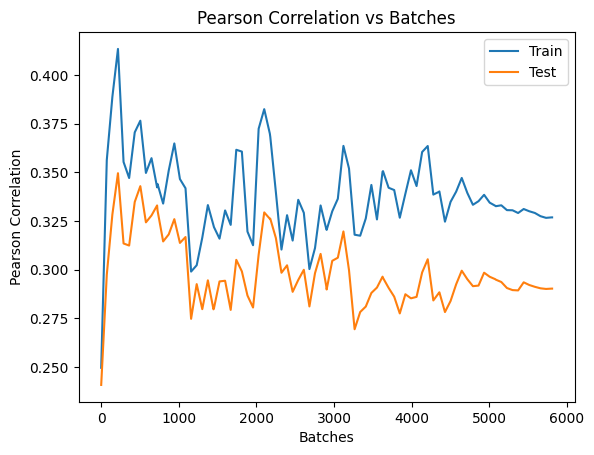

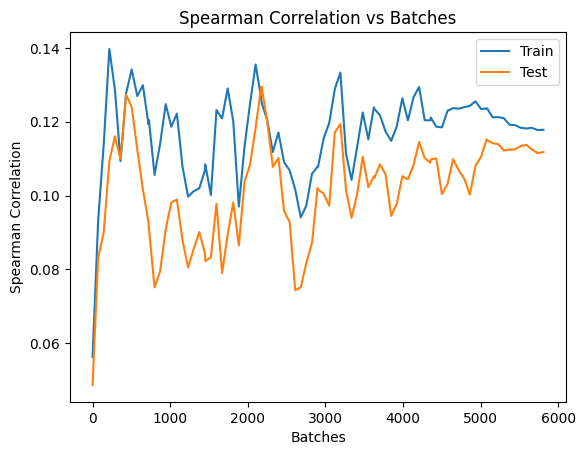

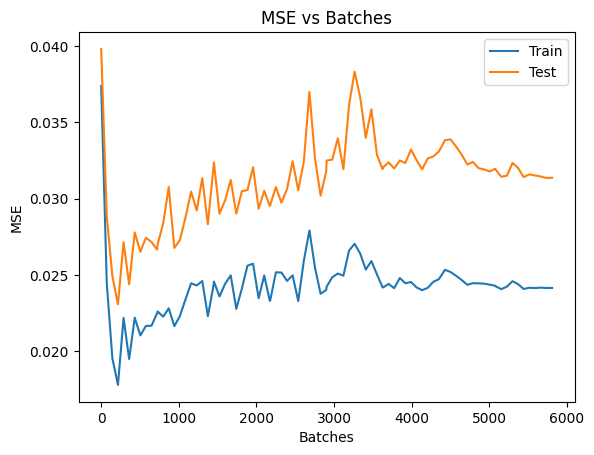

In [8]:
from plot_lprogress import plot_eval

path_eval = os.path.join(output_path, 'eval')

plot_eval(path_eval, num_batches, save=False)